In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (RandomizedLasso, lasso_stability_path)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from load_data import load

# from treeinterpreter import treeinterpreter as ti


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline


def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

X, y, X_test, Id = load()



(1455, 307)
(1455,)
(1459, 307)


In [12]:
lars_cv = LassoLarsCV(cv=10).fit(X, y)


alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)


# X_transform = RandomizedLasso(alpha=alphas, random_state=42, selection_threshold=0.8).fit_transform(X, y)

# alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
# lasso = LassoCV(alphas = alphas)
# lasso.fit(X_transform, y)
# print "rmse transformed_lasso plus lasso cv {}".format(rmse_cv(lasso).mean())
# lin = LinearRegression() # better without skew data log transform
# lin.fit(X_transform, y)
# print "rmse transformed_lasso plus linear cv {}".format(rmse_cv(lin).mean())



/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=7.117e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=4.620e-04, with an active set of 33 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. a

rmse bayes cv 0.113002353353
[(0.1635, 'GrLivArea'), (0.1103, '1stFlrSF'), (0.0802, 'LotArea'), (0.0797, 'Neighborhood_Crawfor'), (0.0742, '_Neighborhood'), (0.0644, 'Exterior1st_BrkFace'), (0.0541, 'Neighborhood_StoneBr'), (0.0477, 'MSZoning_FV'), (0.0418, 'Condition1_Norm'), (0.0406, 'Heating_GasW'), (0.0404, 'OverallCond'), (0.0386, 'OverallQual'), (0.0383, 'Neighborhood_BrkSide'), (0.0362, 'MSZoning_RH'), (0.0361, '_GarageQual'), (0.0344, 'MSZoning_RL'), (0.034, '_OverallQual'), (0.0333, '_Functional'), (0.0324, 'SaleCondition_Normal'), (0.0315, 'LotConfig_CulDSac')]
rmse lasso cv 0.109839667823


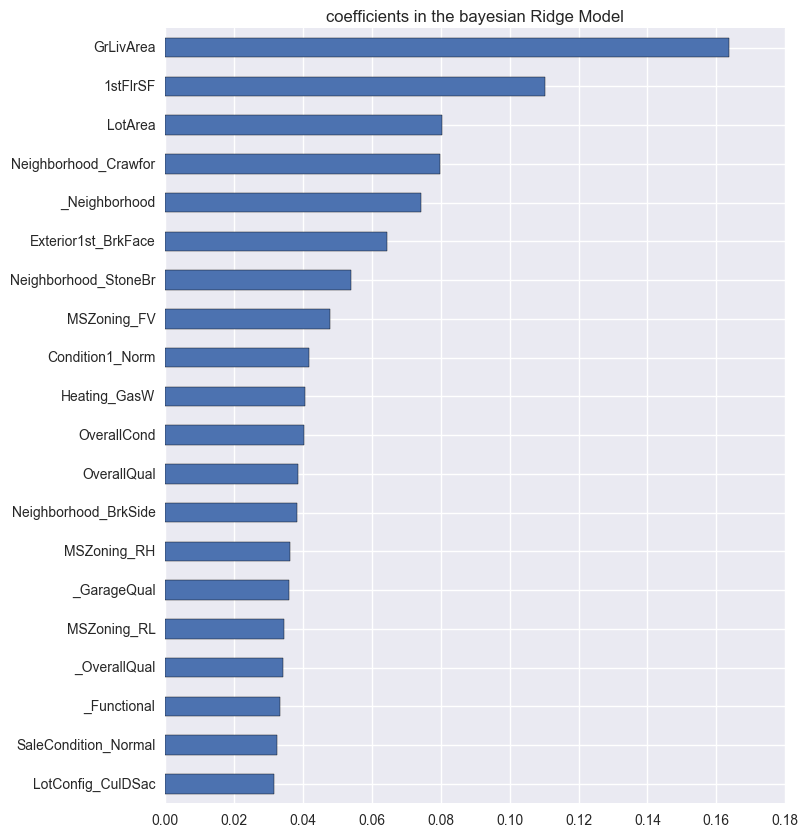

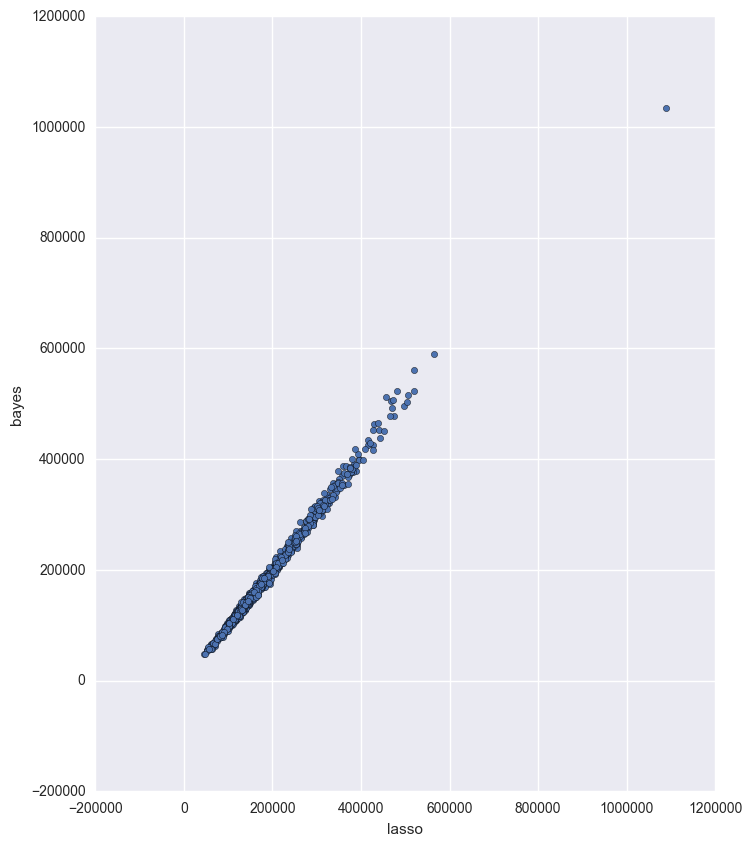

In [18]:
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

bayes = BayesianRidge()
bayes.fit(X, y)
print "rmse bayes cv {}".format(rmse_cv(bayes).mean())
print sorted(zip(map(lambda x: round(x, 4), bayes.coef_), X.columns), reverse=True)[:20]

coef = pd.Series(bayes.coef_, index = X.columns)

imp_coef = coef.sort_values().tail(20)


matplotlib.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("coefficients in the bayesian Ridge Model")




alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
lasso = LassoCV(alphas = alphas)
lasso.fit(X, y)
print "rmse lasso cv {}".format(rmse_cv(lasso).mean())


lasso_preds = np.expm1(lasso.predict(X_test))
bayes_preds = np.expm1(bayes.predict(X_test))


predictions = pd.DataFrame({"lasso":lasso_preds, "bayes":bayes_preds})
predictions.plot(x= "lasso", y = "bayes", kind = "scatter")



In [10]:
bayes = BayesianRidge()
bayes.fit(X, y)
print "rmse bayes cv {}".format(rmse_cv(bayes).mean())

pca  = PCA(n_components=140)
pac_bay = Pipeline([
        ('pca', pca),('bayes', BayesianRidge())
    ])
pac_bay.fit(X, y)
print "rmse pca + bayes cv {}".format(rmse_cv(pac_bay).mean())

rmse bayes cv 0.113002353353
rmse pca + bayes cv 0.115299329609


In [17]:
from sklearn.decomposition import PCA
pca  = PCA(n_components=136)
clf = Pipeline([
        ('pca', pca),('lasso', LassoCV(alphas = [1,0.1, 0.001, 0.0005]))
    ])
clf.fit(X, y)
print "rmse pca + lasso cv {}".format(rmse_cv(clf).mean())

rmse pca + lasso cv 0.116914474169


rmse lasso + bayes cv 0.114516978804


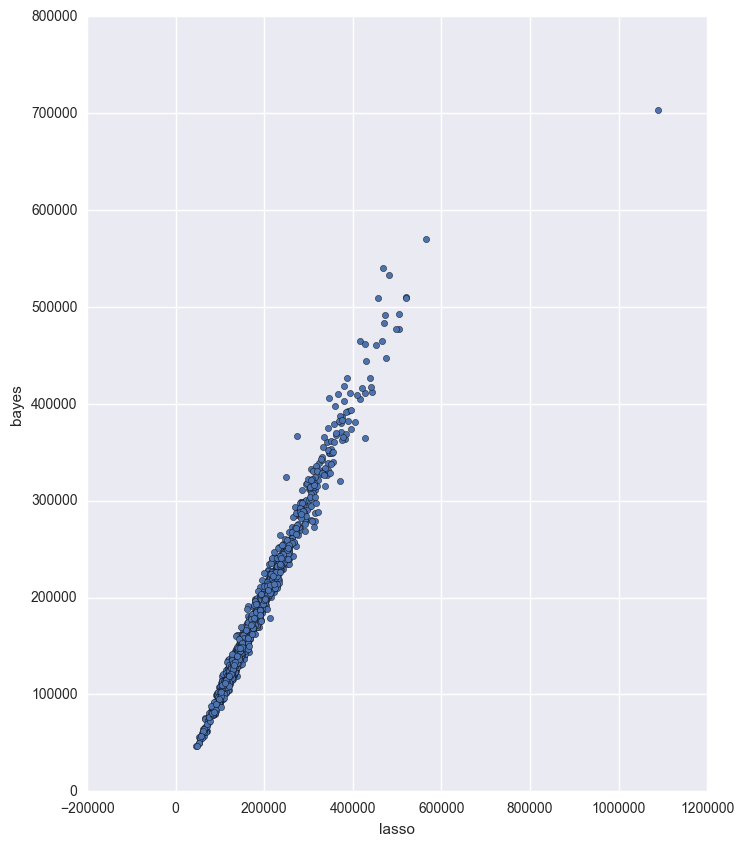

In [21]:
# threshold = 0.25
# while threshold >= 0.00001:
#     clf = Pipeline([
#         ('lasso_select', SelectFromModel(LassoCV(alphas = [1,0.1, 0.001, 0.0005]), threshold=threshold)),
#         ('bayes', bayes)
#     ])

#     clf.fit(X, y)
#     print "threshold:{}".format(threshold)
#     print "rmse lasso select + bayes cv {}".format(rmse_cv(clf).mean())
#     threshold /= 2;
from sklearn.feature_selection import SelectFromModel
    
threshold = 0.00048828125

lasso_bayes = Pipeline([
    ('lasso_select', SelectFromModel(LassoCV(alphas = [1,0.1, 0.001, 0.0005]), threshold=threshold)),
    ('bayes', bayes)
])

lasso_bayes.fit(X, y)

print "rmse lasso + bayes cv {}".format(rmse_cv(bayes).mean())


lasso_bayes_preds = np.expm1(lasso_bayes.predict(X_test))


predictions = pd.DataFrame({"lasso":lasso_preds, "bayes":lasso_bayes_preds})
predictions.plot(x= "lasso", y = "bayes", kind = "scatter")

# preds = 0.5* lasso_preds  + 0.5 *bayes_preds

# solution = pd.DataFrame({"id":Id, "SalePrice":preds})
# solution.to_csv("lasso_bayes.csv", index= False)

In [15]:
pca  = PCA(n_components=144)
clf = Pipeline([
        ('pca', pca),('lasso', ExtraTreesRegressor(100))
    ])
clf.fit(X, y)
print "rmse pca + extra Tree Regressor cv {}".format(rmse_cv(clf).mean())

rmse pca + extra Tree Regressor cv 0.176261069908


In [6]:

pca  = PCA(n_components=144)
pca_ridge = Pipeline([
        ('pca', pca),
        ('Ridge', Ridge())
    ])
pca_ridge.fit(X, y)
print "rmse pca + Ridge cv {}".format(rmse_cv(pca_ridge).mean())



rmse pca + Ridge cv 0.116361391697


In [20]:
from sklearn.linear_model import LinearRegression
pca  = PCA(n_components=144)

lin = LinearRegression()
lin.fit(X, y)
print "rmse linear cv {}".format(rmse_cv(lin).mean())

clf = Pipeline([
        ('pca', pca),('linear', LinearRegression())
    ])
clf.fit(X, y)
print "rmse pca + linear cv {}".format(rmse_cv(clf).mean())

rmse linear cv 0.140928451643
rmse pca + linear cv 0.116821704709


In [68]:
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=ExtraTreesRegressor(), n_estimators=10)
bag.fit(X,y)
print "rmse bagging trees cv {}".format(rmse_cv(bag).mean())



rmse linear cv 0.142005181981


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada_lasso = AdaBoostRegressor(lasso,
                          n_estimators=10)

ada_lasso.fit(X,y)
print "rmse ada+ lasso cv {}".format(rmse_cv(ada_lasso).mean())



rmse ada+ lasso cv 0.129062725716


In [ ]:
from sklearn.grid_search import GridSearchCV



param_test1 = {"alpha": [0.02,0.01, 0.03],'l1_ratio': [0.5,0.6,0.7]}


enet = ElasticNet(max_iter=1000)
search = GridSearchCV(estimator= enet, param_grid = param_test1, n_jobs=4,iid=False, cv=5)

search.fit(X,y)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# enet = ElasticNet(alpha=0.001, l1_ratio=0.5)
# enet.fit(X,y)
# rmse_cv(enet).mean()


/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
